In [83]:
import os
import sys
import scipy.io
import scipy.misc
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import tensorflow as tf

- scipy.io -- Python 在读取matlab文件时常用到scipy.io文件。使用 scipy.io.loadmat 将把matlab中的数组转换成 Python 中的字典，字典的键就是 mat 文件中的变量名：

> `dat=scipy.io.loadmat("test.mat")`

- scipy.misc -- 将数组保存为图像格式：

> `from scipy.misc import imsave`

> `imsave('test.jpg',array)`

- PIL -- PIL是Python中的一个图像处理库。PIL是PY2.x版本的库，在3版本中，PIL对应于库 pillow。PIL库可以完成图像的读入、缩放、切片、旋转、滤镜、输出文字、模糊图像等操作。

> `from PIL import Image`

> `im=Image.open("cat2.jpg") # 打开一个jpg文件`

> `im.show() # 将图片展示出来`

> `im2=im.rotate(45) # 将图片旋转 45 度，并将修改后的结果保存至 im2 `

> `im2.save("output.jpg") # 将对象 im2 保存为 output.jpg 文件`

预训练好的 VGG19 模型在这个链接里：http://www.vlfeat.org/matconvnet/pretrained/

In [11]:
# test -- scipy.io.loadmat(path)
vgg=scipy.io.loadmat("imagenet-vgg-verydeep-19.mat")

In [76]:
# 定义一个常数类
class CONFIG:
    IMAGE_WIDTH = 400
    IMAGE_HEIGHT = 300
    COLOR_CHANNELS = 3
    NOISE_RATIO = 0.6
    MEANS = np.array([123.68, 116.779, 103.939]).reshape((1,1,1,3))
    VGG_MODEL = 'imagenet-vgg-verydeep-19.mat' # 预训练好的 vgg19 模型
    STYLE_IMAGE = 'stone_style.jpg' # 使用的风格图片
    CONTENT_IMAGE = 'content300.jpg' #使用的内容图片
    OUTPUT_DIR = 'output/' # 输出合成图片的目录
    STYLE_LAYERS = [
        ('conv1_1',0.2),
        ('conv2_1',0.2),
        ('conv3_1',0.2),
        ('conv4_1',0.2),
        ('conv5_1',0.2)
    ]
    

# 定义载入vgg19模型的函数
def load_vgg_model(path):
    """
    载入已训练好的VGG-19模型
    """
    vgg = scipy.io.loadmat(path)
    vgg_layers=vgg['layers']
    def _weights(layer,expected_layer_name):
        """
        返回 VGG 模型中某一指定层的权重和偏差参数
        """
        wb = vgg_layers[0][layer][0][0][2] # [0][layer][0][0][2]是参数所在的位置
        W = wb[0][0] #取出参数 layer 层的 W
        b = wb[0][1] # 取出参数 b
        layer_name = vgg_layers[0][layer][0][0][0][0] # conv1_1 or conv1_2 or ...
        assert layer_name == expected_layer_name
        return W,b
    
    def _relu(conv2d_layer):
        """
        返回卷积层的输出值后，经过 RELU 激活后，最后输出的值
        """
        return tf.nn.relu(conv2d_layer)
    
    def _conv2d(prev_layer, layer, layer_name):
        """
        使用预训练模型 VGG19 中 layer 层过滤器的权重和偏差值，计算卷积层的输出值
        """
        W, b= _weights(layer, layer_name)
        W = tf.constant(W)
        b = tf.constant(np.reshape(b,(b.size))) # Why we don't use bias in the next line?
        return tf.nn.conv2d(prev_layer,filter=W,strides=[1,1,1,1],padding="SAME")+b # Cousera notebook is wrong here. We should add bias b.
    
    def _conv2d_relu(prev_layer, layer, layer_name):
        """
        利用 vgg19 模型中 layer 层的权重和偏差值来计算 conv2d+relu 后的输出值
        """
        return _relu(_conv2d(prev_layer, layer, layer_name))
    
    def _avgpool(prev_layer):
        """
        返回平均池化 AveragePooling 层的输出值
        """
        return tf.nn.avg_pool(prev_layer, ksize=[1,2,2,1], strides=[1,2,2,1], padding="SAME")
    
    # 构建模型
    graph = {}
    graph["input"] = tf.Variable(np.zeros((1, CONFIG.IMAGE_HEIGHT, CONFIG.IMAGE_WIDTH, 
                                         CONFIG.COLOR_CHANNELS), dtype="float32"))
    graph["conv1_1"] = _conv2d_relu(graph['input'], 0, 'conv1_1')
    graph["conv1_2"] = _conv2d_relu(graph['conv1_1'],2, 'conv1_2')
    graph['avgpool1'] = _avgpool(graph['conv1_2'])
    graph['conv2_1'] = _conv2d_relu(graph['avgpool1'],5,'conv2_1')
    graph['conv2_2'] = _conv2d_relu(graph['conv2_1'],7,'conv2_2')
    graph['avgpool2'] = _avgpool(graph['conv2_2'])
    graph['conv3_1']  = _conv2d_relu(graph['avgpool2'], 10, 'conv3_1')
    graph['conv3_2']  = _conv2d_relu(graph['conv3_1'], 12, 'conv3_2')
    graph['conv3_3']  = _conv2d_relu(graph['conv3_2'], 14, 'conv3_3')
    graph['conv3_4']  = _conv2d_relu(graph['conv3_3'], 16, 'conv3_4')
    graph['avgpool3'] = _avgpool(graph['conv3_4'])
    graph['conv4_1']  = _conv2d_relu(graph['avgpool3'], 19, 'conv4_1')
    graph['conv4_2']  = _conv2d_relu(graph['conv4_1'], 21, 'conv4_2')
    graph['conv4_3']  = _conv2d_relu(graph['conv4_2'], 23, 'conv4_3')
    graph['conv4_4']  = _conv2d_relu(graph['conv4_3'], 25, 'conv4_4')
    graph['avgpool4'] = _avgpool(graph['conv4_4'])
    graph['conv5_1']  = _conv2d_relu(graph['avgpool4'], 28, 'conv5_1')
    graph['conv5_2']  = _conv2d_relu(graph['conv5_1'], 30, 'conv5_2')
    graph['conv5_3']  = _conv2d_relu(graph['conv5_2'], 32, 'conv5_3')
    graph['conv5_4']  = _conv2d_relu(graph['conv5_3'], 34, 'conv5_4')
    graph['avgpool5'] = _avgpool(graph['conv5_4'])
    
    return graph

def generate_noise_image(content_image, noise_ratio = CONFIG.NOISE_RATIO):
    """
    生成白噪声图片
    """
    noise_image = np.random.uniform(-20,20,(1,CONFIG.IMAGE_HEIGHT,CONFIG.IMAGE_WIDTH,CONFIG.COLOR_CHANNELS))
    input_image = noise_image*noise_ratio + content_image*(1-noise_ratio)
    return input_image

def reshape_and_normalize_image(image):
    """
    对 input_image 进行变形及归一化
    """
    image = np.reshape(image, ((1,)+image.shape)) # Reshape image to match the expected input of VGG19
    
    image = image - CONFIG.MEANS # Subtract the mean to match the expected input of VGG19
    return image

def save_image(path, image):
    image = image + CONFIG.MEANS
    image = np.clip(image[0], 0, 225).astype('uint8')
    scipy.misc.imsave(path, image)
    
def resize_style_image(content_image_path, style_image_path):
    """
    修改风格图片的大小来匹配内容图片的大小
    """
    content_image = scipy.misc.imread(content_image_path)
    style_image = scipy.misc.imread(style_image_path)

    
    if content_image.shape == style_image.shape:
        return content_image, style_image
    else:
        temp_image = Image.open(style_image_path)
        
        if content_image.size < style_image.size:
            # 风格图片大，对风格图片大小进行压缩
            # Image.resize((width,height),format) format用来指定采样的方式
            temp_image = temp_image.resize((content_iamge.shape[1],
                                           content_image.shape[0]),
                                          Image.BICUBIC)  #返回一个 Image 对象
        else:
            # 风格图片小
            temp_image = temp_image.resize((content_image.shape[1],
                                           content_image.shape[0]),
                                          Image.ANTIALIAS) # 返回一个 Image 对象
        return content_image, np.array(temp_image)

In [26]:
model = load_vgg_model("imagenet-vgg-verydeep-19.mat")
print(model)

{'input': <tf.Variable 'Variable_3:0' shape=(1, 300, 400, 3) dtype=float32_ref>, 'conv1_1': <tf.Tensor 'Relu_17:0' shape=(1, 300, 400, 64) dtype=float32>, 'conv1_2': <tf.Tensor 'Relu_18:0' shape=(1, 300, 400, 64) dtype=float32>, 'avgpool1': <tf.Tensor 'AvgPool_5:0' shape=(1, 150, 200, 64) dtype=float32>, 'conv2_1': <tf.Tensor 'Relu_19:0' shape=(1, 150, 200, 128) dtype=float32>, 'conv2_2': <tf.Tensor 'Relu_20:0' shape=(1, 150, 200, 128) dtype=float32>, 'avgpool2': <tf.Tensor 'AvgPool_6:0' shape=(1, 75, 100, 128) dtype=float32>, 'conv3_1': <tf.Tensor 'Relu_21:0' shape=(1, 75, 100, 256) dtype=float32>, 'conv3_2': <tf.Tensor 'Relu_22:0' shape=(1, 75, 100, 256) dtype=float32>, 'conv3_3': <tf.Tensor 'Relu_23:0' shape=(1, 75, 100, 256) dtype=float32>, 'conv3_4': <tf.Tensor 'Relu_24:0' shape=(1, 75, 100, 256) dtype=float32>, 'avgpool3': <tf.Tensor 'AvgPool_7:0' shape=(1, 38, 50, 256) dtype=float32>, 'conv4_1': <tf.Tensor 'Relu_25:0' shape=(1, 38, 50, 512) dtype=float32>, 'conv4_2': <tf.Tensor 

In [81]:
def compute_content_cost(a_C,a_G):
    """
    计算内容损失
    """
    m,n_H,n_W,n_C = a_G.get_shape().as_list()
    a_C_unrolled = tf.transpose(tf.reshape(a_C,shape=[n_H*n_W,-1]))
    a_G_unrolled = tf.transpose(tf.reshape(a_G,shape=[n_H*n_W,-1]))
    J_content = tf.reduce_sum(tf.square(tf.subtract(a_C_unrolled,a_G_unrolled)))/(4*n_H*n_W*n_C)
    return J_content

def gram_matrix(A):
    GA = tf.matmul(A,tf.transpose(A))
    return GA

def compute_layer_style_cost(a_S,a_G):
    """
    计算单层的风格损失
    """
    m,n_H,n_W,n_C = a_G.get_shape().as_list()
    a_S_unrolled = tf.transpose(tf.reshape(a_S,shape=[n_H*n_W,-1]))
    a_G_unrolled = tf.transpose(tf.reshape(a_G,shape=[n_H*n_W,-1]))
    GS = gram_matrix(a_S_unrolled)
    GG = gram_matrix(a_G_unrolled)
    J_style = tf.reduce_sum(tf.square(tf.subtract(GS,GG)))/((2*n_H*n_W*n_C)**2)
    return J_style

def compute_style_cost(model,sess):
    """
    计算总风格损失
    """
    J_style = 0
    for layer_name,coeff in CONFIG.STYLE_LAYERS:
        out = model[layer_name]
        a_S = sess.run(out)
        a_G = out
        J_style_layer = compute_layer_style_cost(a_S,a_G)
        J_style +=J_style_layer
    return J_style

def total_cost(J_content, J_style, alpha=10, beta=40):
    """
    计算总损失
    """
    J = alpha*J_content+beta*J_style
    return J

def construct_network(content_image, style_image,learning_rate=1.0):
    """
    搭建神经网络结构
    """
    tf.reset_default_graph()
    sess = tf.InteractiveSession()
    
    model = load_vgg_model('imagenet-vgg-verydeep-19.mat')
    
    sess.run(model['input'].assign(content_image))
    
    out = model['conv4_2']
    a_C = sess.run(out)
    a_G = out
    J_content = compute_content_cost(a_C,a_G)
    
    sess.run(model['input'].assign(style_image))
    
    J_style = compute_style_cost(model,sess)
    
    J = total_cost(J_content,J_style)
    
    optimizer = tf.train.AdamOptimizer(learning_rate)
    train_step = optimizer.minimize(J)
    
    return sess,train_step,model,J,J_content,J_style

def train_network(sess, train_step, model, content_image,J,J_content,J_style,
                  save_intermidiate=True, num_iterations=120):
    """
    训练神经网络，并保存每20次迭代的合成图片
    """
    generated_image = generate_noise_image(content_image)
    sess.run(tf.global_variables_initializer())
    sess.run(model['input'].assign(generated_image))
    
    for i in range(num_iterations):
        sess.run(train_step)
        
        generated_image = sess.run(model['input'])
        
        if i%20==0:
            Jt, Jc, Js = sess.run([J,J_content,J_style])
            print("Iteration " + str(i) + " :")
            print("total_cost = " + str(Jt))
            print("content cost = " + str(Jc))
            print("style cost = " + str(Js))
            
            if save_intermidiate:
                save_image("output/" + str(i) + ".png", generated_image)
    save_image("output/generated_image.jpg",generated_image)
    
    return generated_image

C:\anaconda\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  This is separate from the ipykernel package so we can avoid doing imports until
C:\anaconda\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  after removing the cwd from sys.path.


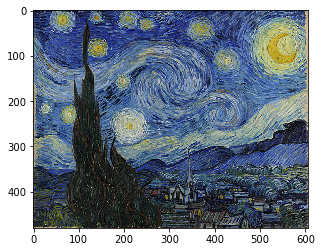

In [89]:
content_image_path = "Van_Gogh_Starry_Night.jpg"
style_image_path = "persian_cat_content.jpg"
c=scipy.misc.imread(content_image_path)
s=scipy.misc.imread(style_image_path)
plt.imshow(c)

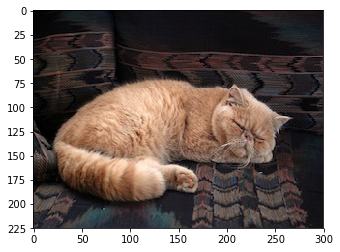

In [90]:
plt.imshow(s)

In [ ]:
% matplotlib inline
content_image_path = "Van_Gogh_Starry_Night.jpg"
style_image_path = "persian_cat_content.jpg"
content_image,style_image = resize_style_image(content_image_path,
                                              style_image_path)
CONFIG.IMAGE_WIDTH = content_image.shape[1]
CONFIG.IMAGE_HEIGHT = content_image.shape[0]

# 这段代码只能运行一次，因为每运行一次以下代码，都会改变图片的形状
content_image = reshape_and_normalize_image(content_image)
style_image = reshape_and_normalize_image(style_image)

sess,train_step,model,J,J_content,J_style = construct_network(content_image, style_image)
generated_image = train_network(sess,train_step,model,content_image,J,J_content,J_style)

C:\anaconda\lib\site-packages\ipykernel_launcher.py:120: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
C:\anaconda\lib\site-packages\ipykernel_launcher.py:121: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
